In [1]:
import torch
from torch.utils.data import DataLoader
from torch.optim import SGD ,AdamW

from datasets import load_dataset, load_metric

import matplotlib.pyplot as plt

import json


In [2]:
import utils_generic as generic
import multitask_dep as mt
import model_confs as confs
import train_dep as train

In [3]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
torch.manual_seed(27)
tasks = ['to','as','about']

In [4]:
model_conf = confs.distilbert_conf
encoding_type = 'relative'

# Datos ConvAI

In [5]:
with open('Datasets\ConvAI2\convai2_complete.json','r') as f:
    data = json.load(f)

In [6]:
vocab = mt.Vocabulary(data['train'],encoding_type)

In [7]:
convai_train = data['train']
convai_val = data['validation']



convai_train_token = generic.tokenize_dataset_with_dependencies(convai_train,['about','to','as'],vocab,model_conf) 
convai_val_token = generic.tokenize_dataset_with_dependencies(convai_val,['about','to','as'],vocab,model_conf) 

In [8]:
convai_train_dataset = mt.DatasetMultitaskDep(convai_train_token,tasks,eval=False)
convai_val_dataset = mt.DatasetMultitaskDep(convai_val_token,tasks,eval=False)

# Datos md_gender

In [9]:
with open('Datasets\md_gender\md_complete.json','r',encoding="utf8") as f:
    md_data = json.load(f)

In [10]:
md_tokenized = generic.tokenize_dataset_with_dependencies(md_data,['about','to','as'],vocab,model_conf) 
md_dataset = mt.DatasetMultitaskDep(md_tokenized,tasks,eval=True)

# Creación dataloaders

In [11]:
dl_train =DataLoader(convai_train_dataset,batch_size=128,shuffle=True,collate_fn=mt.collate_fn)
dl_val =DataLoader(convai_val_dataset,batch_size=128,shuffle=True,collate_fn=mt.collate_fn)
dl_eval = DataLoader(md_dataset,batch_size=128,shuffle=False,collate_fn=mt.collate_fn)

# Modelo multitask

Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertModel: ['vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 2.0480798298058196 	 Validation loss: 2.0070728750552163 	 
  1%|          | 574/57400 [03:24<4:35:26,  3.44it/s]
Epoch 2 	 Training loss: 1.9873725315004276 	 Validation loss: 1.9936131986521057 	 
  2%|▏         | 1148/57400 [06:14<3:44:40,  4.17it/s]
Epoch 3 	 Training loss: 1.9776125107908082 	 Validation loss: 1.9858162706181155 	 
  3%|▎         | 1722/57400 [08:36<3:38:40,  4.24it/s]
Epoch 4 	 Training loss: 1.9702940624765404 	 Validation loss: 1.9814938589677973 	 
  4%|▍         | 2296/57400 [11:01<3:49:50,  4.00it/s]
Epoch 5 	 Training loss: 1.967048790812077 	 Validation loss: 1.979230704954115 	 
  5%|▌         | 2870/57400 [13:27<3:49:09,  3.97it/s]
Epoch 6 	 Training loss: 1.9641088810116571 	 Validation loss: 1.980542087959031 	 

1 epoch without improvement
  6%|▌         | 3444/57400 [15:54<4:37:07,  3.24it/s]
Epoch 7 	 Training loss: 1.9599467601094926 	 Validation loss: 1.9741522861739336 	 
  7%|▋         | 4018/57400 [18:55<4:23:46,  3.37i

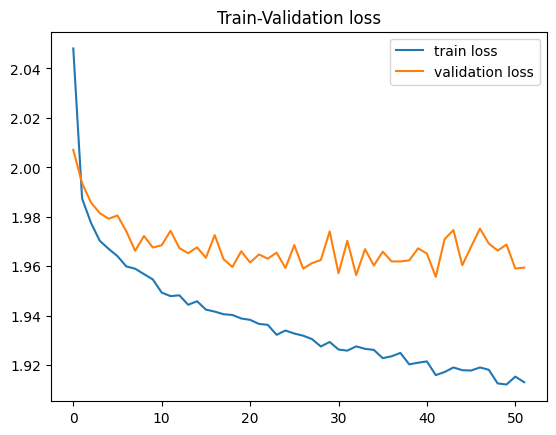

In [12]:
model = mt.MultiWithDependencies(model_conf,vocab).to(device)
save_path='m1_distilbert_multi_adamw'
learning_rate = 1e-6
optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)
num_epochs = 100
train.train_function_multi(model,num_epochs,dl_train,optimizer,early_stop = 10,dl_val = dl_val,save_path=save_path)

In [14]:
model = mt.MultiWithDependencies(model_conf,vocab).to(device)
model.load_state_dict(torch.load(save_path))

print("Accuracy evaluando en todas las etiquetas")
print(train.eval_function_multi(model,dl_eval,tasks))
print("Accuracy evaluando en etiquetas female")
print(train.eval_function_multi(model,dl_eval,tasks,'female'))
print("Accuracy evaluando en etiquetas male")
print(train.eval_function_multi(model,dl_eval,tasks,'male'))

Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertModel: ['vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Accuracy evaluando en todas las etiquetas
{'to': 0.678030303030303, 'as': 0.7288135593220338, 'about': 0.8125}
Accuracy evaluando en etiquetas female
{'to': 0.6561679790026247, 'as': 0.7547169811320755, 'about': 0.8}
Accuracy evaluando en etiquetas male
{'to': 0.6982968369829684, 'as': 0.7045454545454546, 'about': 0.8255208333333334}
